In [ ]:
%cd ~/covariate-dependent-graphical-model

In [2]:
import os

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader

In [3]:
from utils.utils_eval import get_heatmap, get_network_metrics_snapshots
from utils import utils_train
from utils.datasets import RealDatasetWithCovariates
from utils.utils_logging import get_logger
logger = get_logger()

In [4]:
output_dir = 'output/stock'
os.makedirs(output_dir, exist_ok=True)

LOAD_SAVED_MODEL = False
ckpt_dir = 'ckpts'
os.makedirs(ckpt_dir, exist_ok=True)
ckpt_path = os.path.join(ckpt_dir, f'model_checkpoint_stock.pth')

# 0. Load data and some basic data prep

In [5]:
seed = 927
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
info_x = np.load(f'data/stock/x.npz',allow_pickle=True) 
info_z = np.load(f'data/stock/z.npz',allow_pickle=True)
info_x.files, info_z.files

(['x', 'dates', 'tickers', 'sectors'], ['z', 'dates', 'tickers'])

**Note that the data has already been pre-sorted/grouped by sectors**

In [7]:
## multiply by 100 to convert return to percent
x, z = 100*info_x['x'], info_z['z']
z[:,:1] = 100*z[:,:1]
print(x.shape, z.shape)

(5785, 79) (5785, 3)


**Do train/val/test split; train until end of 2017, validate using 2018, 2019, test with 2020 onwards**

In [8]:
val_start, test_start = np.where(info_x['dates']==pd.to_datetime('2018-01-02'))[0][0], np.where(info_x['dates']==pd.to_datetime('2020-01-02'))[0][0]
val_start, test_start

(4276, 4779)

# 1. Set up configs and create dataloaders

In [9]:
network_configs = {
  'model_name': 'dnnCGM',
  'num_nodes': 79,
  'num_covariates': 3,
  'beta_module_name': 'MLP',
  'beta_hidden_dims': 32,
  'beta_dropout': 0.1
}

opt_configs = {
  'learning_rate': 0.001,
  'scheduler_type': 'MultiStepLR',
  'milestones': [20, 50],
  'gamma': 0.5
}
  
train_configs = {
  'max_epochs': 200,
  'gradient_clip_val': 1.0,
  'limit_val_batches': 50,
  'batch_size': 256,
  'verbose': 50,
  'es_patience': None,
  'es_monitor': 'val_loss'
}

In [10]:
utils_train.fix_seed(seed)

In [11]:
train_dataset = RealDatasetWithCovariates(x=x[:val_start], z=z[:val_start])
val_dataset = RealDatasetWithCovariates(x=x[val_start:test_start], z=z[val_start:test_start])
test_dataset = RealDatasetWithCovariates(x=x[test_start:], z=z[test_start:])

In [12]:
train_dl = DataLoader(train_dataset, batch_size=train_configs['batch_size'], num_workers=4, shuffle=True, drop_last=True, persistent_workers=False)
val_dl = DataLoader(val_dataset, batch_size=train_configs['batch_size'], num_workers=4, shuffle=False, drop_last=True, persistent_workers=False)
test_dl = DataLoader(test_dataset, batch_size=train_configs['batch_size'], num_workers=4, shuffle=False, drop_last=False, persistent_workers=False)

# 2. Train the neural network

In [13]:
model, optimizer, scheduler = utils_train.initialize_model_and_optimizer(network_configs,
                                                                         opt_configs,
                                                                         device)

2025-04-22 14:13:56;INFO;utils_train:74 - model dnnCGM initialized on device cuda:0


total number of parameters: 203,538


In [14]:
if LOAD_SAVED_MODEL:
    checkpoint = torch.load(ckpt_path, map_location=device)
    logger.info(f'model ckpt loaded from {ckpt_path}')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
else:
    utils_train.model_fit(model, optimizer, scheduler, train_configs, train_dl, val_dl, output_dir, use_meter=False)
    checkpoint = {'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}
    torch.save(checkpoint, ckpt_path)
    logger.info(f'model ckpt saved to {ckpt_path}')

>> Epoch=001, lr=1.0E-03; train_loss=111.0690; val_loss=8.9977; [timer=1s/epoch]
>> Epoch=050, lr=2.5E-04; train_loss=3.0340; val_loss=1.4590; [timer=0s/epoch]
>> Epoch=100, lr=2.5E-04; train_loss=2.0811; val_loss=1.4186; [timer=0s/epoch]
>> Epoch=150, lr=2.5E-04; train_loss=1.9509; val_loss=1.4238; [timer=0s/epoch]
>> Epoch=200, lr=2.5E-04; train_loss=1.8878; val_loss=1.4296; [timer=0s/epoch]


2025-04-22 14:15:12;INFO;utils_train:230 - model training completed; total time elapsed = 1.25 mins
2025-04-22 14:15:12;INFO;3502875047:10 - model ckpt saved to ckpts/model_checkpoint_stock.pth


In [15]:
## apply the model on the test period
preds, graphs = utils_train.model_predict(model, test_dl)
graphs = (-1) * graphs
graphs.shape

(1006, 79, 79)

In [16]:
test_dates = info_x['dates'][test_start:]
test_dates.min(), test_dates.max()

(Timestamp('2020-01-02 00:00:00'), Timestamp('2023-12-29 00:00:00'))

# 2. Examine Results

In [17]:
import warnings
warnings.simplefilter("ignore", UserWarning)

## 2.0 estimated graphs on specific dates

In [18]:
unique_sector = np.unique(info_x['sectors'])
sector_labels = ['ConDisc', 'ConStap', 'ENERGY', 'FIN', 'HC', 'IND', 'IT', 'RE', 'TELECOM', 'UTILS']
dict_arr, vh_arr, size_arr = [], [], []
for key in np.unique(info_x['sectors']):
    dict_arr.append(np.where(info_x['sectors']==key)[0][0] + len(np.where(info_x['sectors']==key)[0])//2+1)
    vh_arr.append(np.where(info_x['sectors']==key)[0][0])    
    size_arr.append(len(np.where(info_x['sectors']==key)[0]))

In [19]:
sample_id0 = np.where(test_dates == pd.to_datetime('2020-03-23'))[0][0]
sample_id1 = np.where(test_dates == pd.to_datetime('2023-03-23'))[0][0]
sample_id2 = np.where(test_dates == pd.to_datetime('2023-03-30'))[0][0]

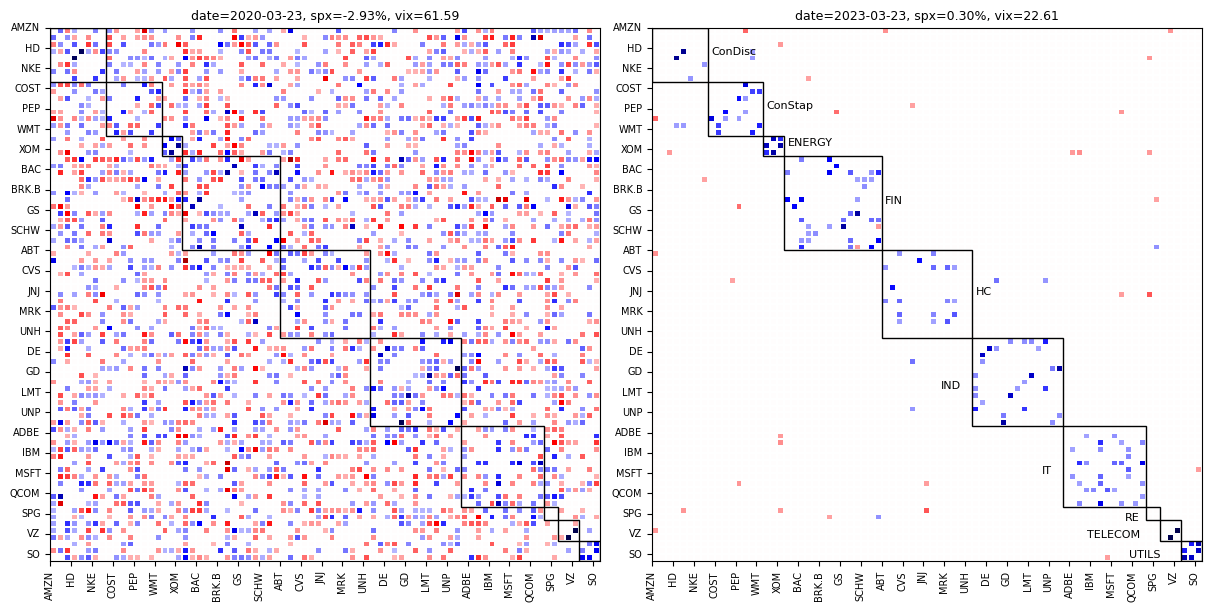

In [20]:
fig, axs = plt.subplots(1,2,figsize=(12,6), constrained_layout=True)

tick_interval = 3
label_tickers = info_x['tickers'][::tick_interval].tolist()
label_tickers.insert(0, label_tickers[0])

graph0 = (graphs[sample_id0] + graphs[sample_id0].transpose())/2
get_heatmap(graph0, axs[0], rm_diag=True, labels=info_x['tickers'], threshold=0.1)
## add patches
for ix, idxv in enumerate(vh_arr):
    rect = patches.Rectangle((idxv, idxv),size_arr[ix],size_arr[ix], linewidth=1, edgecolor='black', facecolor='none')
    axs[0].add_patch(rect)
axs[0].set_title(f'date=2020-03-23, spx={z[test_start+sample_id0,0]:.2f}%, vix={z[test_start+sample_id0,2]:.2f}',fontsize=9)
axs[0].xaxis.set_major_locator(ticker.MultipleLocator(tick_interval))
axs[0].yaxis.set_major_locator(ticker.MultipleLocator(tick_interval))
axs[0].set_xticklabels(labels=label_tickers, rotation=90)
axs[0].set_yticklabels(labels=label_tickers, rotation=0)

graph1 = (graphs[sample_id1] + graphs[sample_id1].transpose())/2
get_heatmap(graph1, axs[1], rm_diag=True, labels=info_x['tickers'], threshold=0.1)
axs[1].set_title(f'date=2023-03-23, spx={z[test_start+sample_id1,0]:.2f}%, vix={z[test_start+sample_id1,2]:.2f}',fontsize=9)
axs[1].xaxis.set_major_locator(ticker.MultipleLocator(tick_interval))
axs[1].yaxis.set_major_locator(ticker.MultipleLocator(tick_interval))
axs[1].set_xticklabels(labels=label_tickers, rotation=90)
axs[1].set_yticklabels(labels=label_tickers, rotation=0)

# add patches
for ix,idxv in enumerate(vh_arr):
    rect = patches.Rectangle((idxv, idxv),size_arr[ix],size_arr[ix], linewidth=1, edgecolor='black', facecolor='none')
    axs[1].add_patch(rect)
    if ix <= len(vh_arr)//2-1:
        axs[1].text(idxv+size_arr[ix]+0.5, idxv+size_arr[ix]/2 , sector_labels[ix],fontsize=8)
    else:
        axs[1].text(idxv-len(sector_labels[ix])*1.5,idxv+size_arr[ix]/2 +1, sector_labels[ix],fontsize=8)

fig.savefig(f'{output_dir}/quiet_day_vs_bad_day.png')

## 2.1 visualize results on the test period, resp. for high and normal VIX dates

In [21]:
full_df = pd.DataFrame(info_x['x'],columns=info_x['tickers'], index=info_x['dates'])
full_df.index.name = 'date'
full_df = full_df.reset_index()
full_df['vix'] = info_z['z'][:,2]
full_df['vix_rank'] = full_df['vix'].rank(pct=True)
stock_cols = info_x['tickers']

test_df = full_df.loc[full_df['date']>=test_dates.min()].copy().reset_index(drop=True)
test_df['vix_rank'] = test_df['vix'].rank(pct=True)

In [22]:
large_vix_date_idx = test_df.loc[test_df.vix_rank >= 0.9].index

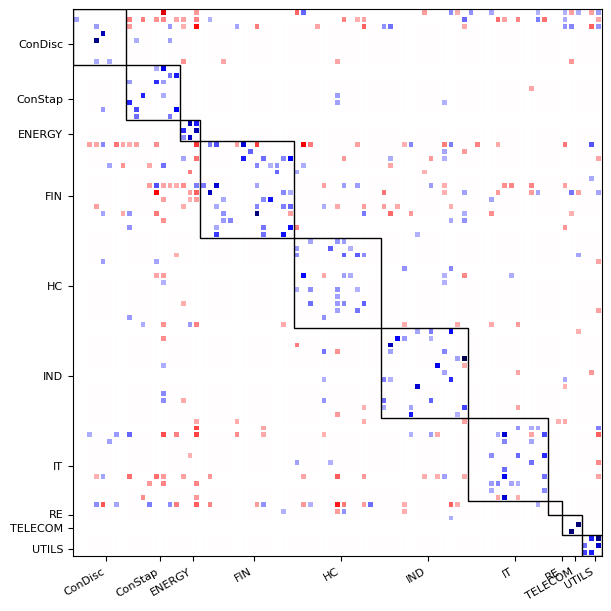

In [23]:
fig, axs = plt.subplots(1,1,figsize=(6,6), constrained_layout=True)

get_heatmap(graphs[large_vix_date_idx,:,:].mean(axis=0), axs, rm_diag=True, labels=info_x['sectors'], threshold=0.1)
axs = plt.gca()
axs.xaxis.set_major_locator(ticker.FixedLocator(dict_arr))
axs.yaxis.set_major_locator(ticker.FixedLocator(dict_arr))
axs.set_xticklabels(labels=sector_labels, rotation=30, ha='right',fontsize=8)
axs.set_yticklabels(labels=sector_labels, rotation=0, ha='right',fontsize=8)

for ix,idxv in enumerate(vh_arr):
# Add the patch to the Axes
    rect = patches.Rectangle((idxv, idxv),size_arr[ix],size_arr[ix], linewidth=1, edgecolor='black', facecolor='none')
    axs.add_patch(rect)
fig.savefig(f'{output_dir}/block_high_vix.png')

In [24]:
small_vix_date_idx = test_df.loc[test_df.vix_rank <= 0.5].index

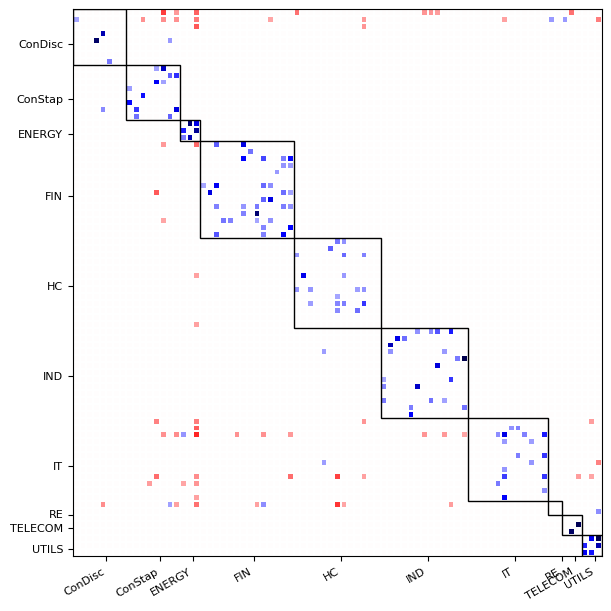

In [25]:
fig, axs = plt.subplots(1,1,figsize=(6,6), constrained_layout=True)

get_heatmap(graphs[small_vix_date_idx,:,:].mean(axis=0), axs, rm_diag=True, labels=info_x['sectors'], threshold=0.1)
axs.xaxis.set_major_locator(ticker.FixedLocator(dict_arr))
axs.yaxis.set_major_locator(ticker.FixedLocator(dict_arr))
axs.set_xticklabels(labels=sector_labels, rotation=30, ha='right',fontsize=8)
axs.set_yticklabels(labels=sector_labels, rotation=0, ha='right',fontsize=8)
for ix, idxv in enumerate(vh_arr):
    rect = patches.Rectangle((idxv, idxv),size_arr[ix],size_arr[ix], linewidth=1, edgecolor='black', facecolor='none')
    axs.add_patch(rect)
fig.savefig(f'{output_dir}/block_normal_vix.png')

## 2.2 visualize connectivity across all dates

In [26]:
preds_test, graphs_test = utils_train.model_predict(model, test_dl)

test_dl_train = DataLoader(train_dataset, batch_size=train_configs['batch_size'], num_workers=4, shuffle=False, drop_last=False, persistent_workers=False)
test_dl_val = DataLoader(val_dataset, batch_size=train_configs['batch_size'], num_workers=4, shuffle=False, drop_last=False, persistent_workers=False)
preds_train, graphs_train = utils_train.model_predict(model, test_dl_train)
preds_val, graphs_val = utils_train.model_predict(model, test_dl_val)

In [27]:
graphs_cat = np.concatenate((graphs_train, graphs_val),axis=0)
graphs_cat = np.concatenate((graphs_cat, graphs_test),axis=0)
graphs_cat = graphs_cat * (-1)
np.save(f'{output_dir}/graphs_all.npy', graphs_cat)

In [28]:
%%time
network_metrics = get_network_metrics_snapshots(graphs_cat, undirected=True, threshold=0.1)
d_metrics = pd.DataFrame(network_metrics).drop(columns=['t'])
d_metrics.index = info_x['dates']
d_metrics['vix'] = z[:,2]
d_metrics = d_metrics.reset_index()

CPU times: user 1min 18s, sys: 0 ns, total: 1min 18s
Wall time: 1min 18s


In [29]:
important_dates = [pd.to_datetime('2001-09-17'), 
                   pd.to_datetime('2008-11-20'),
                   pd.to_datetime('2010-05-06'),
                   pd.to_datetime('2011-08-08'),
                   pd.to_datetime('2020-03-23')]
events = ['911', 'Global Financial Crisis', 'Flash Crash', 'European Sovereign Debt Crisis', 'Covid']
xidx = full_df.loc[full_df.date.isin(important_dates)].index

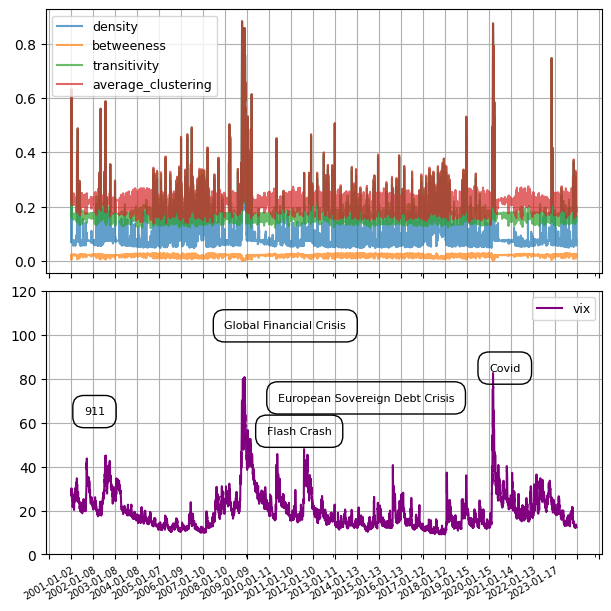

In [30]:
fig, axs = plt.subplots(2,1,figsize=(6,6), constrained_layout=True,sharex =True)
for key_v in ['density', 'betweeness', 'transitivity', 'average_clustering']:
    d_metrics[key_v].plot(ax=axs[0],label=key_v, alpha=0.7)
axs[0].legend(fontsize=9)
axs[0].grid()

d_metrics['vix'].plot(ax=axs[1],label='vix',color='purple')
tick_interval = 252
labels_raw = full_df.date.astype(str)[0::tick_interval].tolist()
labels = labels_raw.copy()
labels.insert(0, labels[0])

axs[1].xaxis.set_major_locator(ticker.MultipleLocator(tick_interval))
axs[1].set_xticklabels(labels, rotation=30, ha='center',fontsize=7)

for ix, idxv in enumerate(xidx):
    axs[1].text(idxv-len(events[ix])*10, d_metrics['vix'].values[idxv]+22, events[ix] ,fontsize=8, 
                bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))

axs[1].set_ylim(0,120)
axs[1].legend(fontsize=9)
axs[1].grid()

fig.savefig(f'{output_dir}/graph_statistics.png')